In [322]:
!pip install regex

In [877]:
import numpy as np
import regex as re
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
from ipywidgets import widgets, interact

In [901]:
# Transformar un string binario a un numero decimal
def binToDec(binary): 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

# Transformar un decimal a un numero binario
def decToBin(n): 
    return bin(n).replace("0b","") 

# Regla definida en la pregunta 6
def regla(vec):
    vec = int(vec)
    dec = binToDec(vec)
    if dec in [0,1,4,5,6,8,9,10,14]:
        return 0
    else:
        return 1
    
def decToTer(num):
    ternary = ""
    while(num != 0):
        ternary+=str(num % 3)
        num = num // 3
    return ternary[::-1]

def terToDec(ter):
    decimal, i, n = 0, 0, 0
    while(ter != 0): 
        dec = ter % 10
        decimal = decimal + dec * pow(3, i) 
        ter = ter//10
        i += 1
    return decimal

In [1048]:
# Generar un regla ECA
def ECArule(number):
    codeBin = decToBin(number)
    lista = []
    i = 0
    for bina in codeBin[::-1]:
        if bina == "1":
            lista.append(i)
        i+=1
        
    def regla(vec):
        vec = int(vec)
        dec = binToDec(vec)
        if dec in lista:
            return 1
        else:
            return 0
    return regla

# Generar una regla para 3 estados posibles
def terRule(number):
    seqRule = decToTer(number)
    seqRule = seqRule.zfill(27)
    lista1 = []
    lista2 = []
    i = 0
    for ter in seqRule[::-1]:
        if ter == "1":
            lista1.append(i)
        elif ter == "2":
            lista2.append(i)
        i+=1
    def regla(vec):
        vec = int(vec)
        dec = terToDec(vec)
        if dec in lista1:
            return 1
        elif dec in lista2:
            return 2
        else:
            return 0
    return regla

# Generar diccionario de subsecuencias de largo b_length 
#  encontradas en sequence
def create_dictionary(sequence, b_length):
    dic = set()
    for i in range(len(sequence)-b_length+1):
        dic.add(sequence[i:i+b_length])
    return list(dic)

# Calcular la entropia de una secuencia (sequence) dado un largo 
#  de bloque b_length
def entropy(sequence, b_length):
    n = len(sequence)-b_length+1
    pitatoria = 1
    dictionary = create_dictionary(sequence, b_length)
    sub_sequences = re.findall(r'\d{'+str(b_length)+'}', sequence, overlapped=True)
    for word in dictionary:
        p = sub_sequences.count(word)/n
        pitatoria *= p
    return -np.log2(pitatoria)/n

# Generador de secuencias binarias aleatorias de largo length
def random_state(length):
    numbers = np.random.choice(2, length, p=[0.5, 0.5])
    return ''.join(str(n) for n in numbers)

# Generador de secuencias ternarias aleatorias de largo length
def random_state3(length):
    numbers = np.random.choice(3, length, p=[1/3, 1/3, 1/3])
    return ''.join(str(n) for n in numbers)

# Generador de secuencias binarias aleatorias de largo length
def random_traffic(length):
    track1 = np.random.choice(2, length, p=[0.5, 0.5])
    track2 = np.random.choice(2, length, p=[0.5, 0.5])
    return (track1, track2)

# Generador de secuencias binarias aleatorias de largo length
def random_cachipun(length):
    matrix = np.zeros((length, length))
    for i in range(length):
        matrix[i] = np.random.choice(3, length, p=[1/3, 1/3, 1/3])
    return matrix

Se utilizó la siguiente definición de [entropía empírica](https://stats.stackexchange.com/questions/28178/what-is-empirical-entropy#28252):

$$H(\hat{p})=-\dfrac{1}{n}\log\left(\hat{p}\left(x^n\right)\right)$$

# Pregunta 6

In [910]:
# Automata celular con condiciones periódicas

class Autocelu:
    
    def __init__(self, init_state, rule, l_bound, r_bound):
        self.state = init_state # Estado actual de automata
        self.rule = rule # Regla del automata
        self.l_bound = l_bound # Limite izq. de la vecindad
        self.r_bound = r_bound # Limite der. de la vecindad
        self.size_bound = r_bound-l_bound # Tamanio de la vecindad
        self.size = len(init_state) # Tamanio del automata
        self.hist = [init_state] # Historial del automata
        self.entropy_hist = []
        self.name = rule.__name__+str(self.size)
        
    # Calcular la entropia y registrarla
    
    def calc_entropy(self, size_block):
        self.entropy_hist.append(entropy(self.state, size_block))
    
    # Aplicar la regla sobre el automata    
    
    def next(self, ent=False):
        
        next_state = ""
        for i in range(self.size):
            
            vecindad = ""
            for j in range(self.l_bound+i,self.r_bound+i+1):
                vecindad += self.state[j%self.size]
            
            next_bit = str(self.rule(vecindad))
            next_state += next_bit
            
            # Descomentar para mostrar vecindad y resultado de cada aplicacion de la regla
            #print(vecindad+" "+next_bit)
        if ent:
            self.calc_entropy(4)
        self.hist.append(next_state)
        self.state = next_state
    
    # Aplicar n_iter veces la regla al automata
    
    def iter(self, n_iter, ent=False):
        for i in range(n_iter):
            self.next(ent)
    
    # Devolver el automata a su estado inicial
    
    def reset(self):
        self.state = self.hist[0]
        self.hist = [self.state]
        aux = self.entropy_hist[0]
        self.entropy_hist = [aux]
    
    # Devuelve una lista con los estados del automata 
    
    def historial(self):
        return self.hist
    
    # Muestra el automata repetido length veces, para visualizar dinamicas en el borde
    
    def view(self, length=1):
        matrix = np.zeros((len(self.hist), self.size*length),int)
        row = np.zeros(self.size*length)
        i = 0
        for item in self.hist:
            row[:] = [int(c) for c in item]*length
            matrix[i] = row
            i+=1
        fig, ax = plt.subplots(figsize=(14,7))
        plt.imshow(matrix, cmap='Greys',  interpolation='nearest')
        plt.colorbar()
        plt.savefig(self.name+'.png')
        plt.show()
        
    # Devuelve una lista con las entropias
    
    def historial_ent(self):
        return self.entropy_hist

In [911]:
init = random_state(200)

# Estado inicial es un string
ac = Autocelu(init, regla, -2, 1)

In [912]:
ac.iter(100)

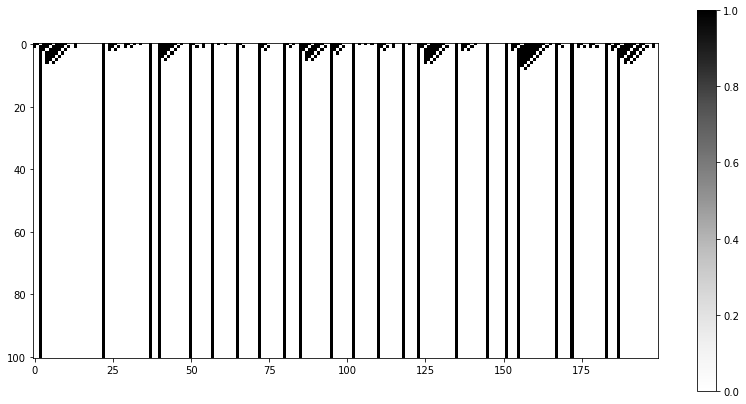

In [913]:
ac.view(1)

Según lo observado, el autómata no corresponde a uno conservativo (1s desaparecen)

# Pregunta 8

Más arriba se define un creador de reglas terRule que imita el estándar ECA, pero en una configuración ternaria.

Por ejempo la regla 44 en este sistema corresponde a:

$44_{10} = 1122_3$

|Ternario|Decimal|Ternario|Decimal|Ternario|Decimal|
|:---:|:---:|:---:|:---:|:---:|:---:|
| 000 | 2   | 100 | 0 | 200 | 0 |
| 001 | 2   | 101 | 0 | 201 | 0 |
| 002 | 1   | 102 | 0 | 202 | 0 |
| 010 | 1   | 110 | 0 | 210 | 0 |
| 011 | 0   | 111 | 0 | 211 | 0 |
| 012 | 0   | 112 | 0 | 212 | 0 |
| 020 | 0   | 120 | 0 | 220 | 0 |
| 021 | 0   | 121 | 0 | 221 | 0 |
| 022 | 0   | 122 | 0 | 222 | 0 |

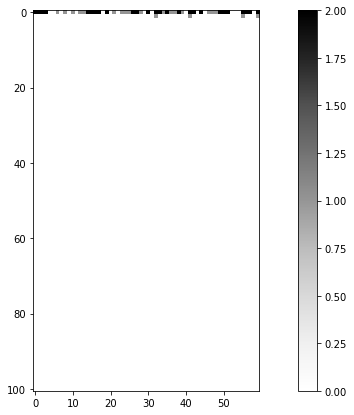

In [1026]:
init = random_state3(60)
regla31 = terRule(6561)
# Estado inicial es un string
ac31 = Autocelu(init, regla31, -1, 1)
ac31.iter(100)
ac31.view(1)

Se observa que las reglas de la forma:
$$3^k,\quad 2\leq k \leq8\ |\ k \in \mathbb{N}$$

son de clase 1, es decir llegan a un punto fijo, luego de pocas iteraciones.

En particular se muestra la regla $6561=3^8$.

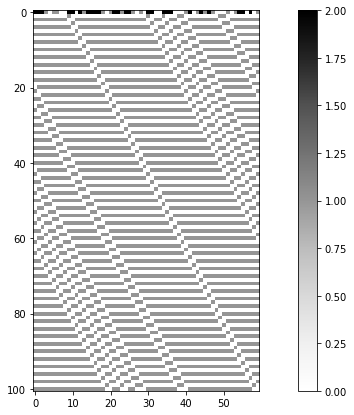

In [1027]:
init = random_state3(60)
regla32 = terRule(6565)
# Estado inicial es un string
ac32 = Autocelu(init, regla32, -1, 1)
ac32.iter(100)
ac32.view(1)

La regla 6565 tiene un comportamiento periódico, por lo tanto es de Clase 2.

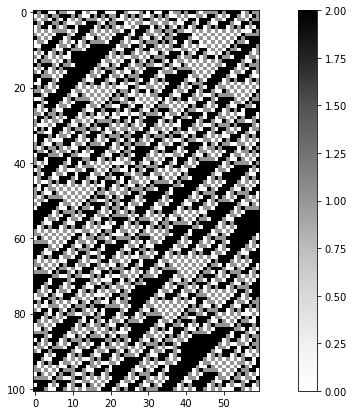

In [1047]:
init = random_state3(60)
regla33 = terRule(1561156198126216)
# Estado inicial es un string
ac33 = Autocelu(init, regla33, -1, 1)
ac33.iter(100)
ac33.view(1)

Dado que no es posible observar patrones claros, el automata definido por la regla 1561156198126216 puede considerarse de Clase 3.

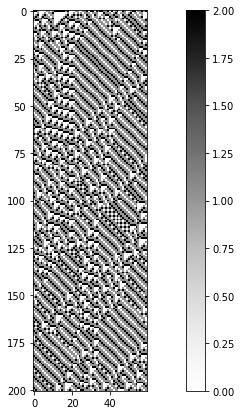

In [1046]:
init = random_state3(60)
regla34 = terRule(15611561985216)
# Estado inicial es un string
ac34 = Autocelu(init, regla34, -1, 1)
ac34.iter(200)
ac34.view(1)

El patrón formado parece tener regularidades, pero no son claramente periódicas. Esto indica que la regla 15611561985216 podría considerarse de Clase 4.

# Pregunta 9

In [370]:
# Definir reglas requeridas

rule108 = ECArule(108)
rule110 = ECArule(110)
rule126 = ECArule(126)
rule160 = ECArule(160)

In [452]:
m=100

#### Regla 108

In [453]:
total_ent108 = np.zeros(100)
for i in tqdm(range(m)):
    init = random_state(5000)
    ac = Autocelu(init, rule108, -1, 1)
    ac.iter(100,True)
    ent = ac.historial_ent()
    total_ent108 += ent
total_ent108/=m

##### Gráfico de entropía

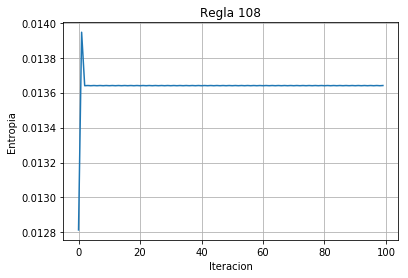

In [455]:
plt.plot(np.arange(0,100), total_ent108)

plt.xlabel('Iteracion')
plt.ylabel('Entropia')
plt.title('Regla 108')
plt.grid(True)
plt.show()

##### Muestra de 100 iteraciones de un AC de tamaño 20

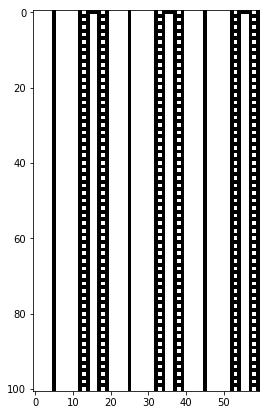

In [551]:
init=random_state(20)
ac108 = Autocelu(init, rule108, -1, 1)
ac108.iter(100)
ac108.view(3)

Se observa que la entropía incrementa en un principio y luego se estanca a partir de una iteración, porque como se observa en el ejemplo, el AC llega a un punto fijo.

Dada esta descripción, pertenecen a la Clase I.

#### Regla 110

In [456]:
total_ent110 = np.zeros(100)
for i in tqdm(range(m)):
    init = random_state(5000)
    ac = Autocelu(init, rule110, -1, 1)
    ac.iter(100,True)
    ent = ac.historial_ent()
    total_ent110 += ent
total_ent110/=m

##### Gráfico de entropía

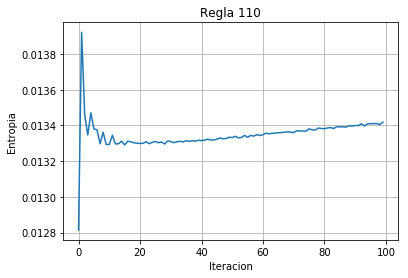

In [458]:
plt.plot(np.arange(0,100), total_ent110)

plt.xlabel('Iteracion')
plt.ylabel('Entropia')
plt.title('Regla 110')
plt.grid(True)
plt.show()

##### Muestra de 100 iteraciones de un AC de tamaño 20

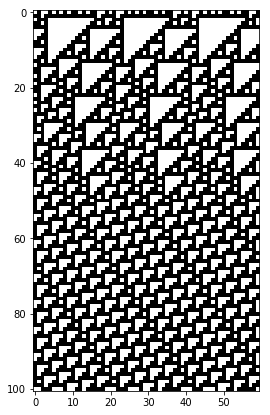

In [565]:
init=random_state(20)
ac110 = Autocelu(init, rule110, -1, 1)
ac110.iter(100)
ac110.view(3)

Se observa que la entropía incrementa, luego decae para finalmente aumentar lentamente. En el ejemplo, se observa un comportamiento enventualmente periódico.

Dada esta descripción, pertenece a la Clase 2.

#### Regla 126

In [459]:
total_ent126 = np.zeros(100)
for i in tqdm(range(m)):
    init = random_state(5000)
    ac = Autocelu(init, rule126, -1, 1)
    ac.iter(100,True)
    ent = ac.historial_ent()
    total_ent126 += ent
total_ent126/=m

##### Gráfico de entropía

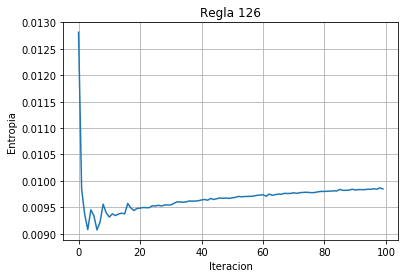

In [461]:
plt.plot(np.arange(0,100), total_ent126)

plt.xlabel('Iteracion')
plt.ylabel('Entropia')
plt.title('Regla 126')
plt.grid(True)
plt.show()

##### Muestra de 100 iteraciones de un AC de tamaño 20

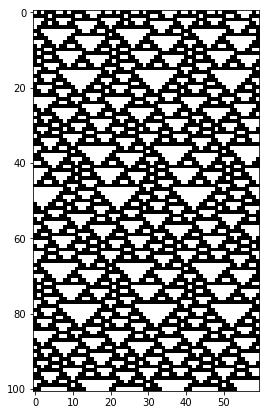

In [567]:
init=random_state(20)
ac126 = Autocelu(init, rule126, -1, 1)
ac126.iter(100)
ac126.view(3)

Comportamiento muy similar al de la regla 110, entropía oscila para finalmente aumentar levemente.

Por su periodicidad, pertenece a la Clase 2.

##### Regla 160

In [462]:
total_ent160 = np.zeros(100)
for i in tqdm(range(m)):
    init = random_state(5000)
    ac = Autocelu(init, rule160, -1, 1)
    ac.iter(100,True)
    ent = ac.historial_ent()
    total_ent160 += ent
total_ent160/=m

##### Gráfico de entropía

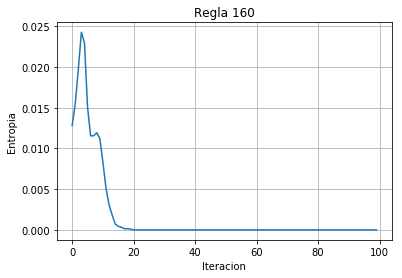

In [464]:
plt.plot(np.arange(0,100), total_ent160)

plt.xlabel('Iteracion')
plt.ylabel('Entropia')
plt.title('Regla 160')
plt.grid(True)
plt.show()

##### Muestra de 100 iteraciones de un AC de tamaño 20

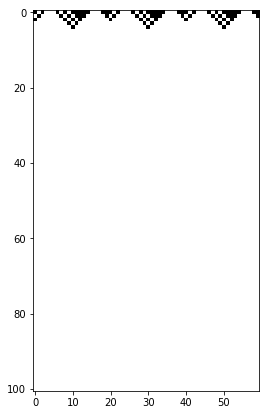

In [556]:
init=random_state(20)
ac160 = Autocelu(init, rule160, -1, 1)
ac160.iter(100)
ac160.view(3)

Comportamiento similar a la regla 108, entropía llega a 0 ya que AC cae en un punto fijo.

Pertenece a la Clase 1.

# Pregunta 10

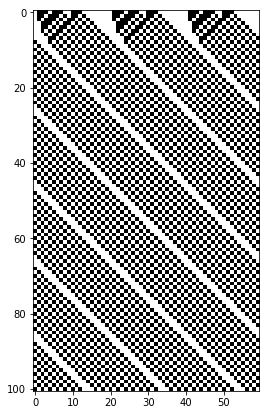

In [577]:
init=random_state(20)
ac184 = Autocelu(init, ECArule(184), -1, 1)
ac184.iter(100)
ac184.view(3)

In [732]:
class Traffic:
    
    def __init__(self, init_t1, init_t2):
        # Se asume que ambas vias tienen el mismo largo
        self.size = len(init_t1)
        # track1 es la via superior, track2 inferior
        self.track1 = init_t1
        self.track2 = init_t2
        # Historial del trafico en las vias
        self.hist = [[init_t1, init_t2]]
        # Contar ctdad de autos en ambas vias
        self.ncars = 0
        unique, counts = np.unique(init_t1, return_counts=True)
        elements = dict(zip(unique, counts))
        if 1 in elements:
            self.ncars += elements[1]
        unique, counts = np.unique(init_t2, return_counts=True)
        elements = dict(zip(unique, counts))
        if 1 in elements:
            self.ncars += elements[1]
        # Densidad = #Autos/Largo_carretera
        self.density = self.ncars/self.size
        # Historial de flujo
        # Flujo inicial es 0
        self.flux_hist = [0]
    
    # Aplicar regla sobre el trackA, observando el trackB
    def apply_rule(self, trackA, trackB):
        next_trackA = np.zeros(self.size)
        next_trackB = np.zeros(self.size)
        index = 0
        total_v = 0
        for pos in trackA:
            # v=0
            vpos=0
            if pos:
                der = (index+1)%self.size
                izq = (index-1)%self.size
                # Si esta vacio a la derecha: avanzar, v=1
                if not trackA[der]:
                    next_trackA[der] = 1
                    vpos=1
                # Si no, cambiarse de via
                elif not trackB[izq] and not trackB[index]:
                    next_trackA[index] = 0
                    next_trackB[index] = 1
                # Si no, quedarse quieto
                else:
                    next_trackA[index] = 1
            # Velocidad acumulada
            total_v+=vpos
            index+=1
        return (next_trackA, next_trackB, total_v)
        
    def next(self):
        # Aplicar regla a ambas vias
        next_track1_, next_track2_, tot_v_ = self.apply_rule(self.track1, self.track2)
        next_track2, next_track1, tot_v = self.apply_rule(self.track2, self.track1)
        # Juntar resultados
        next_track1+=next_track1_
        next_track2+=next_track2_
        tot_v += tot_v_
        # Guardar historial, actualizar trafico
        self.hist.append([next_track1, next_track2])
        self.track1 = next_track1
        self.track2 = next_track2
        # Flujo=vel_prom*densidad
        self.flux_hist.append(tot_v*self.density/self.ncars)
        
    def iter(self, n_iter):
        for i in range(n_iter):
            self.next()
    
    def show(self, time):
        matrix = np.zeros((len(self.hist[time]), self.size),int)
        i = 0
        for track in self.hist[time]:
            matrix[i] = track
            i+=1

        fig, ax = plt.subplots(figsize=(14,7))
        plt.imshow(matrix, cmap='Greys',  interpolation='nearest')
        plt.title("density: "+str(self.density)+"  flux: "+str(self.flux_hist[time]))
        plt.show()
    
    def show_hist(self):
        return self.hist

In [803]:
# correr la siguientes 3 celdas para experimentar con distintas
#  distribuciones

# Generar trafico inicial aleatorio de largo definido por argumento
t1,t2 = random_traffic(20) 

# Definir automata
sim1 = Traffic(t1,t2)
T = 20 # Tiempo maximo

In [804]:
# Iterar T veces
sim1.iter(T)

In [805]:
interact(sim1.show, time=widgets.IntSlider(min=0,max=T,step=1,value=0));

El objeto que se encuentra arriba es un widget y cambia en tiempo real a medida que se ajusta el deslizador.

Luego de realizar diversos experimentos se observa que el sistema intenta ajustarse, para evitar 'tacos'. Dentro de esta dinámica se detectan 3 casos:

Siendo $\rho$ la densidad del sistema:

* $\rho\geq1$: El flujo del sistema converge a $2-\rho$. No necesariamente llega, depende de la distribución de los autos si es que es capaz de deshacerse de los tacos. 
* $\rho<1$: El flujo del sistema converge a $\rho$.
    
Respecto a la densidad que maximiza el flujo; se observa empíricamente que los objetos tienden a posicionarse con una distribución de tablero de ajedrez, lo que les permite tener espacio libre hacia adelante, hacia atrás y hace el lado. Otra opción equivalente, es la de dos autos lado a lado, con las casillas de adelante y atrás de cada uno libres. Con esta premisa la densidad que maximiza el flujo corresponderá a $1$, de manera que la cantidad de autos sea igual al largo de la carretera.

Finalmente, el automáta luego de cierta cantidad de pasos parece caer en una dinámica periódica inevitablemente.

# Pregunta 11

In [831]:
# True si a le gana a b
def win(a, b):
    c = (a-b)%3
    if c==1:
        return True
    else:
        return False

In [887]:
class Cachipun:
    # 0:Piedra
    # 1:Papel
    # 2:Tijeras
    def __init__(self, init_state):
        self.size = init_state.shape[0]
        self.state = init_state #size x size matrix
        self.hist = [init_state]
    
    def rule(self, i, j):
        
        mid = self.state[i][j]
        left = self.state[(i-1)%self.size][j]
        right = self.state[(i+1)%self.size][j]
        top = self.state[i][(j+1)%self.size]
        bot = self.state[i][(j-1)%self.size]
        
        if win(left, mid):
            return left
        elif win(right, mid):
            return right 
        elif win(top, mid):
            return top
        elif win(bot, mid):
            return bot
        else:
            return mid
        
    def next(self):
        next_state = np.zeros((self.size, self.size))
        
        for i in range(self.size):
            for j in range(self.size):
                next_state[i][j] = self.rule(i, j)
                
        self.state = next_state
        self.hist.append(next_state)
    
    def iter(self, n_iter):
        for i in range(n_iter):
            self.next()
            
    def show_hist(self):
        return self.hist
    
    def show(self, time):
        fig, ax = plt.subplots(figsize=(14,7))
        # Blanco: piedra
        # Gris: papel
        # Negro: tijeras
        cmap = colors.ListedColormap(['white', 'red', 'black'])
        img = plt.imshow(self.hist[time], cmap=cmap,  interpolation='nearest')
        plt.colorbar()
        plt.title("Cachipun")
        plt.show()

In [896]:
# Tamaño de la matriz
n = 100
# Numero de iteraciones
T = 100
# Distribucion inicial aleatoria
init = random_cachipun(n)

sim2 = Cachipun(init)
sim2.iter(T)
interact(sim2.show, time=widgets.IntSlider(min=0,max=T,step=1,value=0));

Siempre considerando:

* Piedra: 0
* Papel: 1
* Tijeras: 2

Se observa una dinámica bastante estable del sistema, es decir ningún estado prevalece sobre otro. A simple vista, parecen ondas en una superficie de agua.

Dado que la regla se puede interpretar como que una celda se propaga si es que le gana a sus vecinos, es posible percibir continuidad de algunos bloques moviéndose en el sistema.

De manera más técnica, no parece que esta posea una naturaleza periódica, ni que se acerque a algún punto fijo.

In [895]:
# Tamaño de la matriz
n = 100
# Numero de iteraciones
T = 100
# Distribucion homogénea (solo piedras)
init = np.zeros((n,n))
# Perturbacion (dos papeles en el 'centro')
init[int(n/2)][int(n/2)]=1
init[int(n/2)][int(n/2)+1]=1
sim3 = Cachipun(init)
sim3.iter(T)
interact(sim3.show, time=widgets.IntSlider(min=0,max=T,step=1,value=0));

Con una distribución inicial de solo piedras, excepto dos papeles en el centro, se tiene que este estado domina el tablero luego de 100 iteraciones, esto por razones obvias (papel le gana a la piedra). 

Hacia el final de la simulación los colores cambiar por el escalamiento que realiza el algoritmo, pero se puede seguir la pista de lo que sucede observando la leyenda del costado.

In [894]:
# Tamaño de la matriz
n = 100
# Numero de iteraciones
T = 100
# Distribucion homogénea (solo piedras)
init = np.zeros((n,n))
# Perturbacion (dos papeles en el 'centro')
init[int(n/2)][int(n/2)]=1
init[int(n/2)][int(n/2)+1]=1
# 'Caja' de tijeras
init[int(n/2)-1][:]=2
sim4 = Cachipun(init)
sim4.iter(T)
interact(sim4.show, time=widgets.IntSlider(min=0,max=T,step=1,value=0));

Para probar qué sucede con la inclusión de un tercer elemento, se añade una franja de tijeras en contacto los dos papeles (de otra forma las piedras consumirían la franja).

El resultado es un patrón bastante vistoso, que tiene una naturaleza periódica y se apodera del tablero luego de 100 iteraciones. Destaca el hecho de que las tres clases parecen llegar a cierto equilibrio.